# Look into Magic Feature
reference: https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600

In [12]:
import sys
sys.path.append('/tmp/working/IEEE_Fraud_Detection/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions.functions import load_datasets

In [5]:
# dataのロード
train, test = load_datasets(["transaction_identity_merged"])


### カラムDはtime_deltaである。  
D1-D15: timedelta, such as days between previous transaction, etc.

In [11]:
#D columns
d_cols = ['D' + str(i+1) for i in range(15)]

train[d_cols].head(10)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
6,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
7,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,40.0,302.0,NaN,NaN,NaN,318.0


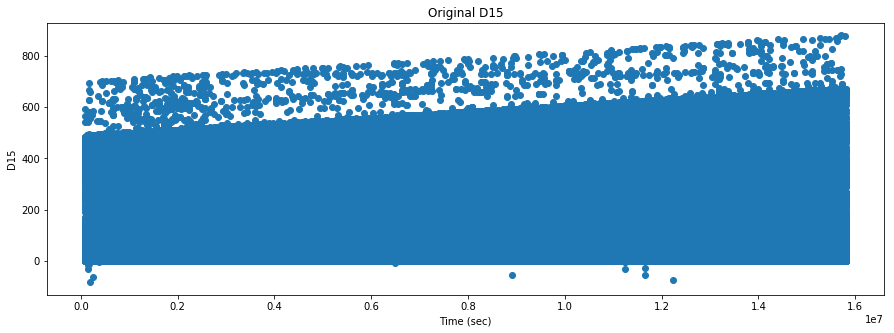

In [14]:
# plot original D15
plt.figure(figsize=(15, 5))
plt.scatter(train['TransactionDT'], train['D15'])
plt.title('Original D15')
plt.xlabel('Time (sec)')
plt.ylabel('D15');

In [16]:
# D columnsのunique check
for i in range(1, 16):
    print('D'+str(i) + ' n unique:', train['D'+str(i)].nunique())
    print('-'*50)

D1 n unique: 641
--------------------------------------------------
D2 n unique: 641
--------------------------------------------------
D3 n unique: 649
--------------------------------------------------
D4 n unique: 808
--------------------------------------------------
D5 n unique: 688
--------------------------------------------------
D6 n unique: 829
--------------------------------------------------
D7 n unique: 597
--------------------------------------------------
D8 n unique: 12353
--------------------------------------------------
D9 n unique: 24
--------------------------------------------------
D10 n unique: 818
--------------------------------------------------
D11 n unique: 676
--------------------------------------------------
D12 n unique: 635
--------------------------------------------------
D13 n unique: 577
--------------------------------------------------
D14 n unique: 802
--------------------------------------------------
D15 n unique: 859
------------------------

In [17]:
train['D9'].unique()

array([       nan, 0.        , 0.041666  , 0.083333  , 0.125     ,
       0.166666  , 0.208333  , 0.25      , 0.291666  , 0.33333299,
       0.416666  , 0.45833299, 0.5       , 0.54166597, 0.58333302,
       0.625     , 0.66666597, 0.70833302, 0.75      , 0.79166597,
       0.83333302, 0.875     , 0.91666597, 0.95833302, 0.375     ])

In [18]:
# Normalize D columns
for i in range(1, 16):
    if i in [1, 2, 3, 5, 9]: continue   # continue以下はスキップして次の繰り返しへ
    train['D' + str(i)] = train['D'+str(i)] - train['TransactionDT'] / np.float32(24*60*60)
    test['D' + str(i)] = test['D'+str(i)] - test['TransactionDT'] / np.float32(24*60*60)

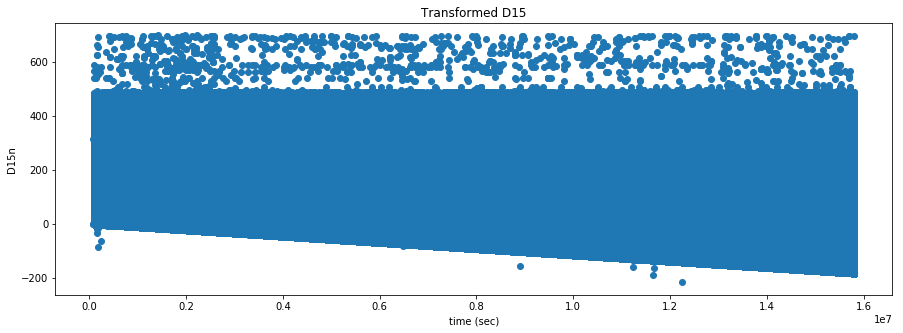

In [22]:
# plot transformed D
plt.figure(figsize=(15, 5))
plt.scatter(train['TransactionDT'], train['D15'])
plt.title('Transformed D15')
plt.xlabel('time (sec)')
plt.ylabel('D15n');

### Encoding Functions

In [63]:
# Frequency Encode Together
def endoce_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col], df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()   #normalize=Trueで相対的な頻度にしている。
        vc[-1] = -1   # この操作は何？？
        nm = col + '_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm, ', ', end='')

        
# Label Encode
def encode_LE(col, train, test, verbose=True):
    df_comb = pd.concat([train[col], test[col]])
    df_comb, _ = df_comb.factorize(sort=True)   #factorize: カテゴリカル変数に。Noneは-1
    nm = col
    if df_comb.max() > 32000:
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[:len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    
    del df_comb; x=gc.collect()
    if verbose:
        print(nm, ', ', end='')   # end=''で改行なし


# Group Aggregation Mean and Std
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, testf_df=X_test,
             fillna=True, usena=False):
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column + '_' + col + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
                if usena:
                    temp_df.loc[temp_df[main_column]==-1, main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                # groupby([col])[main_column] でpd.
                # reset_index()はdrop=Trueを指定しなければ旧インデックスがデータ列に移動する
                # agg(['mean'])のように、aggregateする集計方法を[]でくくってやると、カラム名になる（くくらなければ変化なし）
                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict() #keyがindex, valueが該当行の値
                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name] = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')

                
# Combine Features
def en

SyntaxError: invalid syntax (<ipython-input-63-824c4754fb62>, line 59)